In [1]:
import pandas as pd
import numpy as np
from time import time
import re
import string
import socket
from glob import glob
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import seaborn as sns

In [2]:
country_code = "US"
print('Country:', country_code)

print('Hostname:', socket.gethostname())
if 'samuel' in socket.gethostname().lower():
    path_to_data='../../data'
else:
    path_to_data='/scratch/spf248/twitter/data'
print('Path to data:',path_to_data) 

iterations=range(2)
labels=['is_hired_1mo', 'is_unemployed', 'job_offer', 'job_search', 'lost_job_1mo']
models=['GLOVE','BERT']

Country: US
Hostname: Samuels-MBP.home
Path to data: ../../data


In [3]:
print('Extract labeled tweets:\n')
labeled_tweets=pd.read_pickle(os.path.join(path_to_data,'classification',country_code,'labeling','labels.pkl'))
print('# labeled tweets:', labeled_tweets.shape[0])

Extract labeled tweets:

# labeled tweets: 13620


In [4]:
training_files=glob(os.path.join(path_to_data,'classification',country_code,'labeling','*','sampled','training','*'))
training_tweets=pd.DataFrame()
for training_file in training_files:
    if '.pkl' in training_file:
        tmp=pd.read_pickle(training_file)
    elif '.parquet' in training_file:
        tmp=pd.read_parquet(training_file)
    else:
        print('Extension error:', training_file)
    tmp.tweet_id=tmp.tweet_id.astype(str)
    training_tweets=pd.concat([training_tweets,tmp])
training_tweets=training_tweets.drop_duplicates('tweet_id')[['tweet_id','text']]
print('# training tweets:', training_tweets.shape[0])

Extension error: ../../data/classification/US/labeling/0/sampled/training/_SUCCESS
# training tweets: 11724


In [5]:
sample_files=glob(os.path.join(path_to_data,'classification',country_code,'labeling','*','sampled','evalproc','*'))
precisions=[]
for iteration in iterations:
    print()
    print('********* Iteration:',iteration,'*********')
    for model in models:
        print()
        print('****** Model:',model,'******')
        for label in labels:
            print('*** Label:',label,'***')
            f_tmp=[f for f in sample_files if label in f and model.lower() in f.lower() and 'it'+str(iteration) in f]
            if len(f_tmp)!=1:
                print('>>>CHECK INPUT FILES<<<')
            else:
                tmp=pd.read_pickle(f_tmp[0])[['tweet_id','text']]
                tmp.tweet_id=tmp.tweet_id.astype(str)
                tmp=tmp.merge(labeled_tweets[['tweet_id',label]],on='tweet_id')
                tmp=tmp.drop_duplicates('tweet_id')
                tmp=tmp[-tmp.tweet_id.isin(training_tweets.tweet_id)].copy()
                tmp[label]=tmp[label].apply(lambda x:{'yes':1,'no':0,'unsure':np.nan}[x])
                tmp.dropna(inplace=True)
                tmp.reset_index(drop=True,inplace=True)
                tmp.to_csv(os.path.join(path_to_data,'classification',country_code,'labeling',str(iteration),'labeled','evalproc','labels_iteration_'+str(iteration)+'_'+model+'_'+label+'.csv'),index=False)
                print('# Tweets:', tmp.shape[0])
                precisions.append([iteration,model,label,tmp[label].mean()])
precisions=pd.DataFrame(precisions,columns=['Iteration','Model','Label','Precision'])


********* Iteration: 0 *********

****** Model: GLOVE ******
*** Label: is_hired_1mo ***
# Tweets: 84
*** Label: is_unemployed ***
# Tweets: 95
*** Label: job_offer ***
# Tweets: 97
*** Label: job_search ***
# Tweets: 88
*** Label: lost_job_1mo ***
# Tweets: 92

****** Model: BERT ******
*** Label: is_hired_1mo ***
# Tweets: 91
*** Label: is_unemployed ***
# Tweets: 89
*** Label: job_offer ***
# Tweets: 96
*** Label: job_search ***
# Tweets: 92
*** Label: lost_job_1mo ***
# Tweets: 91

********* Iteration: 1 *********

****** Model: GLOVE ******
*** Label: is_hired_1mo ***
>>>CHECK INPUT FILES<<<
*** Label: is_unemployed ***
>>>CHECK INPUT FILES<<<
*** Label: job_offer ***
>>>CHECK INPUT FILES<<<
*** Label: job_search ***
>>>CHECK INPUT FILES<<<
*** Label: lost_job_1mo ***
>>>CHECK INPUT FILES<<<

****** Model: BERT ******
*** Label: is_hired_1mo ***
# Tweets: 70
*** Label: is_unemployed ***
# Tweets: 82
*** Label: job_offer ***
# Tweets: 95
*** Label: job_search ***
# Tweets: 92
*** 

In [14]:
labeled_files=glob(os.path.join(path_to_data,'classification',country_code,'labeling','*','labeled','evalproc','*'))
precisions=[]
for iteration in iterations:
    print()
    print('********* Iteration:',iteration,'*********')
    for model in models:
        print()
        print('****** Model:',model,'******')
        for label in labels:
            print('*** Label:',label,'***')
            f_tmp=[f for f in labeled_files if label in f and model.lower() in f.lower() and str(iteration)+'_' in f]
            if len(f_tmp)!=1:
                print('>>>CHECK INPUT FILES<<<')
            tmp=pd.read_csv(f_tmp[0])
            precisions.append([iteration,model,label,tmp[label].mean()])
precisions=pd.DataFrame(precisions,columns=['Iteration','Model','Label','Precision'])
precisions.to_csv(os.path.join(path_to_data,'classification',country_code,'precision_high_scored_tweets.csv'))


********* Iteration: 0 *********

****** Model: GLOVE ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***

****** Model: BERT ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***

********* Iteration: 1 *********

****** Model: GLOVE ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***

****** Model: BERT ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***


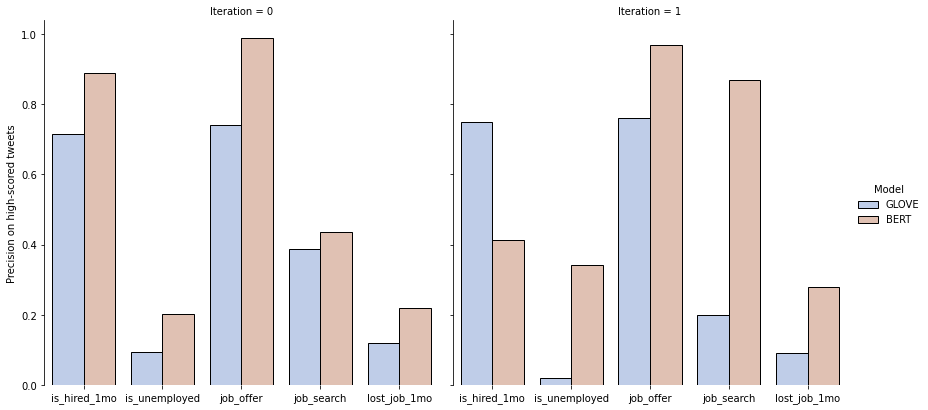

In [12]:
g=sns.catplot(
x="Label", 
y="Precision",
hue="Model",
col="Iteration",
data=precisions, 
kind="bar",
saturation=.5,
height=6, 
aspect=1,
palette="coolwarm",
edgecolor='k');
g.set_axis_labels("", "Precision on high-scored tweets").despine(bottom=True)
plt.savefig(os.path.join(path_to_data,'../fig','precision_top_tweets_random_sample.pdf'),bbox_inches='tight')